In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Start Spark session
spark = SparkSession.builder.appName("StudentPerformanceProject").getOrCreate()


In [5]:
# Load MIDMARKS.csv (place in same folder or give full path)
df = spark.read.csv("MIDMARKS.csv", header=True, inferSchema=False)

# Rename M-II to safe column name
df = df.withColumnRenamed("M-II", "M_II")
df.show()

+----+-------+---+----+---+----+---+----+
|S.NO|SECTION| DV|M_II| PP|BEEE| FL|FIMS|
+----+-------+---+----+---+----+---+----+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|
|   9|  ALPHA| 10|  18|  A|  20| 19|  15|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|
|  13|  ALPHA| 16|  18| 11|  15| 19|  15|
|  14|  ALPHA| 17|  17| 18|  11| 15|   9|
|  15|  ALPHA| 19|  20| 20|  20| 18|  12|
|  16|  ALPHA| 13|  18| 17|  19| 16|   9|
|  17|  ALPHA| 15|  17| 18|  17| 17|  13|
|  18|  ALPHA| 11|   8| 18|  15| 19|  15|
|  19|  ALPHA| 14|  12| 16|  16| 20|  14|
|  20|  ALPHA| 19|  17| 20|  20| 20|  18|
+----+-------+---+----+---+----+--

In [6]:
# Subject columns
subject_cols = ["DV", "M_II", "PP", "BEEE", "FL", "FIMS"]

# Convert marks to int (AB/M/empty -> 0)
for c in subject_cols:
    df = df.withColumn(c, when(col(c).rlike(r'^\s*\d+\s*$'), col(c).cast(IntegerType())).otherwise(0))

# Fill missing SECTION
df = df.withColumn("SECTION", when(col("SECTION").isNull(), "Unknown").otherwise(col("SECTION")))

# Remove duplicate student entries
df = df.dropDuplicates(["S.NO"])
df.show

<bound method DataFrame.show of DataFrame[S.NO: string, SECTION: string, DV: int, M_II: int, PP: int, BEEE: int, FL: int, FIMS: int]>

In [8]:
# Add total marks
df = df.withColumn("total_marks", sum([col(c) for c in subject_cols]))

# Add coding rank (based on PP marks)
df = df.withColumn("coding_rank",
                   when(col("PP") >= 18, "Excellent")
                   .when(col("PP") >= 15, "Good")
                   .when(col("PP") >= 10, "Average")
                   .otherwise("Poor"))
df.show


<bound method DataFrame.show of DataFrame[S.NO: string, SECTION: string, DV: int, M_II: int, PP: int, BEEE: int, FL: int, FIMS: int, total_marks: int, coding_rank: string]>

In [9]:
pdf = df.toPandas()

# Add percentage & grade
pdf["percentage"] = (pdf["total_marks"] / (len(subject_cols) * 20)) * 100
pdf["grade"] = pd.cut(pdf["percentage"],
                      bins=[0,40,50,60,70,85,100],
                      labels=["F","D","C","B","A","O"])

# Add programming skills & DA skills (example logic)
pdf["Programming skills"] = np.where(pdf["PP"]>=15, "Strong", "Weak")
pdf["DA SKILLS"] = np.where(pdf["DV"]>=15, "Good", "Basic")
df.show

<bound method DataFrame.show of DataFrame[S.NO: string, SECTION: string, DV: int, M_II: int, PP: int, BEEE: int, FL: int, FIMS: int, total_marks: int, coding_rank: string]>

In [14]:
#Visualization

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


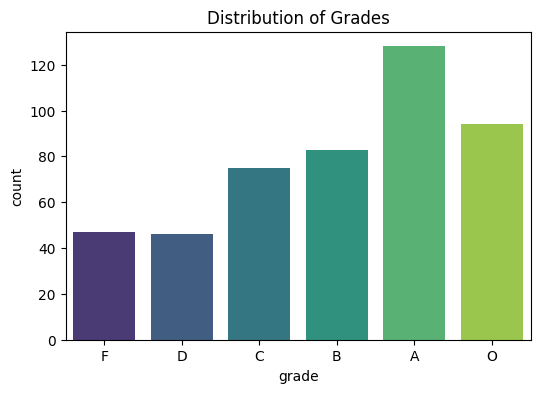

In [22]:
plt.figure(figsize=(6,4))
sns.countplot(x="grade", data=pdf, palette="viridis",legend=False)
plt.title("Distribution of Grades")
plt.show()


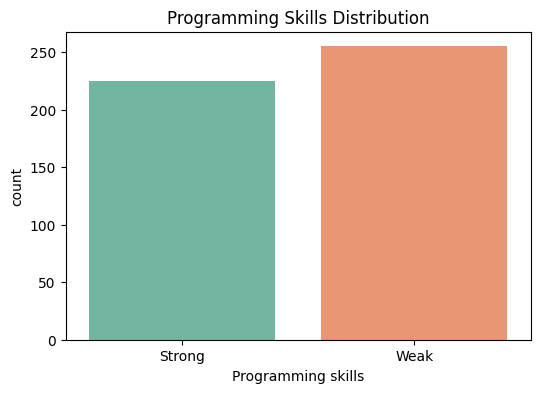

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x="Programming skills", data=pdf, palette="Set2")
plt.title("Programming Skills Distribution")
plt.show()


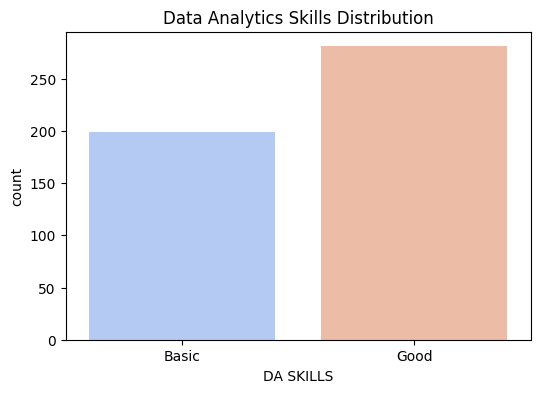

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x="DA SKILLS", data=pdf, palette="coolwarm")
plt.title("Data Analytics Skills Distribution")
plt.show()


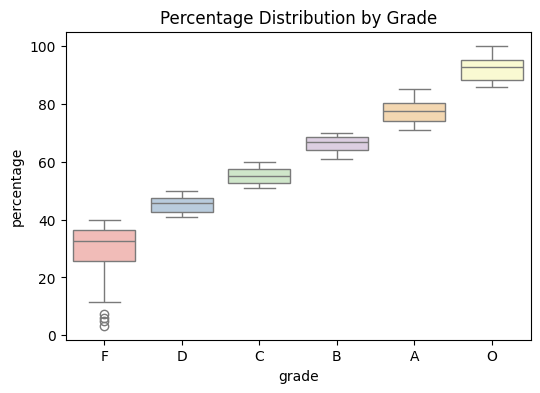

In [25]:
plt.figure(figsize=(6,4))
sns.boxplot(x="grade", y="percentage", data=pdf, palette="Pastel1")
plt.title("Percentage Distribution by Grade")
plt.show()


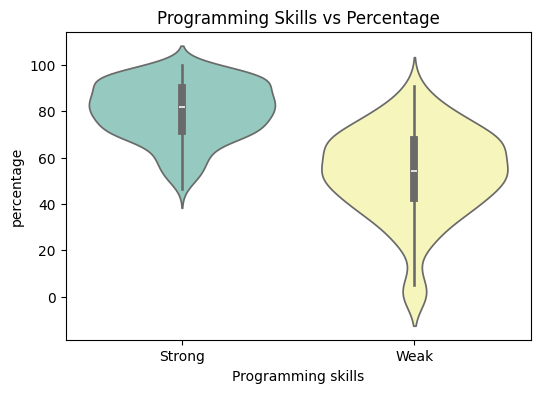

In [26]:
plt.figure(figsize=(6,4))
sns.violinplot(x="Programming skills", y="percentage", data=pdf, palette="Set3")
plt.title("Programming Skills vs Percentage")
plt.show()


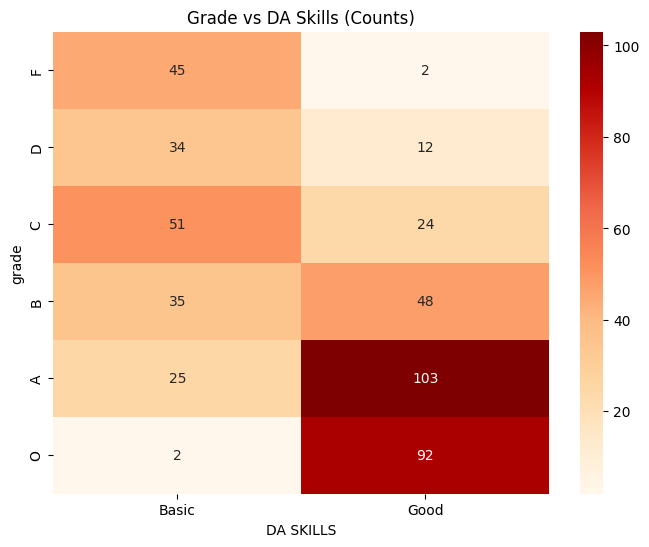

In [27]:
cross_da = pd.crosstab(pdf["grade"], pdf["DA SKILLS"])
plt.figure(figsize=(8,6))
sns.heatmap(cross_da, annot=True, cmap="OrRd", fmt="d")
plt.title("Grade vs DA Skills (Counts)")
plt.show()


In [28]:
print("Top 10 Students by Total Marks:")
display(pdf.sort_values("total_marks", ascending=False).head(10))

print("\nSubject-wise Average Marks:")
display(pdf[subject_cols].mean())

print("\nSubject Difficulty Ranking (lowest avg = hardest):")
print(pdf[subject_cols].mean().sort_values())


Top 10 Students by Total Marks:


,S.NO,SECTION,DV,M_II,PP,BEEE,FL,FIMS,total_marks,coding_rank,percentage,grade,Programming skills,DA SKILLS
416,474,Unknown,20,20,20,20,20,20,120,Excellent,100.000000,O,Strong,Good
414,472,Unknown,20,20,20,20,20,20,120,Excellent,100.000000,O,Strong,Good
357,420,SIGMA,20,20,20,20,20,19,119,Excellent,99.166667,O,Strong,Good
156,24,ALPHA,20,20,20,20,20,18,118,Excellent,98.333333,O,Strong,Good
73,165,DELTA,20,20,20,20,20,18,118,Excellent,98.333333,O,Strong,Good
342,407,OMEGA,20,20,20,20,20,18,118,Excellent,98.333333,O,Strong,Good
448,70,BETA,20,20,20,19,20,18,117,Excellent,97.500000,O,Strong,Good
138,223,EPSILON,20,20,20,17,20,20,117,Excellent,97.500000,O,Strong,Good
381,442,Unknown,20,19,20,19,20,19,117,Excellent,97.500000,O,Strong,Good
19,116,BETA,20,20,20,20,20,17,117,Excellent,97.500000,O,Strong,Good



Subject-wise Average Marks:


DV      14.229167
M_II    10.041667
PP      12.829167
BEEE    13.095833
FL      15.431250
FIMS    13.516667
dtype: float64


Subject Difficulty Ranking (lowest avg = hardest):
M_II    10.041667
PP      12.829167
BEEE    13.095833
FIMS    13.516667
DV      14.229167
FL      15.431250
dtype: float64
